In [1]:
! pip install tensorflow_history_plot

In [2]:
import io
import os
import re
import shutil
import string
import tensorflow as tf

from datetime import datetime
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow_history_plot import show_acc

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # Visible devices must be set at program startup
    print(e)

# Dataset

这个项目主要是做情感分类，顺带学习一下词嵌入的相关内容。用到的数据集叫aclImdb_v1，是用于二进制情绪分类的大型电影评论数据集，其涵盖比基准数据集更多的数据，其中有 25,000 条电影评论用于训练，25,000 条用于测试，还有其他未经标记的数据可供使用，该数据集包含原始文本和已处理的单词格式包。

In [4]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
os.listdir(dataset_dir)

['imdb.vocab', 'train', 'README', 'imdbEr.txt', 'test']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_pos.txt',
 'labeledBow.feat',
 'pos',
 'unsupBow.feat',
 'urls_neg.txt',
 'neg',
 'urls_unsup.txt',
 'unsup']

unsup文件夹用不到，需要删除，防止影响我们构建Dataset。

In [6]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

从训练集里分20%作为验证集

In [7]:
batch_size = 64
seed = 123
train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    os.path.join(dataset_dir,'train'), batch_size=batch_size, validation_split=0.2, 
    subset='training', seed=seed)
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    os.path.join(dataset_dir,'train'), batch_size=batch_size, validation_split=0.2, 
    subset='validation', seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


看看数据集大概长啥样

In [8]:
for text_batch, label_batch in train_ds.take(1):
      for i in range(5):
            print(label_batch[i].numpy(), text_batch.numpy()[i])

1 b"I have watched this movie well over 100-200 times, and I love it each and every time I watched it. Yes, it can be very corny but it is also very funny and enjoyable. The camp shown in the movie is a real camp that I actually attended for 7 years and is portrayed as camp really is, a great place to spend the summer. Everyone who has ever gone to camp, wanted to go to camp, or has sent a child to camp should see this movie because it'll bring back wonderful memories for you and for your kids."
1 b'This movie is SOOOO funny!!! The acting is WONDERFUL, the Ramones are sexy, the jokes are subtle, and the plot is just what every high schooler dreams of doing to his/her school. I absolutely loved the soundtrack as well as the carefully placed cynicism. If you like monty python, You will love this film. This movie is a tad bit "grease"esk (without all the annoying songs). The songs that are sung are likable; you might even find yourself singing these songs once the movie is through. This m

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Text Preprocessing

## 标准化

文本预处理要处理几件事：
* 把所有字母转成小写字母
* 把"\<br />"替换成空格
* 去除所有标点符号

In [10]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

看看处理效果

In [11]:
for text_batch, label_batch in train_ds.take(1):
      for i in range(5):
            print(label_batch[i].numpy(), custom_standardization(text_batch.numpy()[i]))

1 tf.Tensor(b'this is a good example a film that in spite of the low rating is more than worth watching the story is engaging and it doesnt take long before the chemistry between nicole kidman and ben chaplin grabs your attention the acting is first class and the characters are represented well sometimes it feels like the director couldnt decide himself between drama and romantic comedy ben chillers portrayal of the law abiding and shy englishman with porn sm magazines hidden in the bedroom creates plenty of moments for laughs as does the look in nicole kidmans eyes when she is offering john his first taste of intimacy in a long time other times the actors and especially nicole kidman give this comedy quite expertly a dramatic slant', shape=(), dtype=string)
1 tf.Tensor(b'i recently had the pleasure of seeing the big bad swim at the ft lauderdale film festival and i must say it is the best film i have seen all year and the only film i have ever felt inspired to write a commentreview on

## Vectorization Layer
tf提供了vectorization layer来将字符串标准化、切割、将单个字符串映射成一个整数。

In [12]:
vocab_size = 10000

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int')

把字典构造出来

In [13]:
text_ds = train_ds.map(lambda x, y: x) #去除label
vectorize_layer.adapt(text_ds)

看看字典长啥样，比较长取20个看看

In [14]:
vectorize_layer.get_vocabulary()[:20]

['',
 '[UNK]',
 'the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'in',
 'it',
 'i',
 'this',
 'that',
 'was',
 'as',
 'with',
 'for',
 'movie',
 'but',
 'film']

# Build Model

In [15]:
embedding_dim=16

model = Sequential([
  vectorize_layer,
  Embedding(vocab_size, embedding_dim, name="embedding",mask_zero=True),
  GlobalAveragePooling1D(),
  Dense(16, activation='relu'),
  Dense(1)
])

GlobalAveragePooling1D()是把一个batch里的词向量求平均值，忽略了语序等影响。后面会考虑使用RNN

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

结果只有positive和negative，是二元分类，所以loss函数用的是BinaryCrossentropy

In [17]:
history1 = model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=15)

Epoch 1/15
313/313 [==============================] - 6s 16ms/step - loss: 0.6631 - accuracy: 0.5239 - val_loss: 0.4199 - val_accuracy: 0.7976
Epoch 2/15
313/313 [==============================] - 4s 12ms/step - loss: 0.3546 - accuracy: 0.8537 - val_loss: 0.2877 - val_accuracy: 0.8802
Epoch 3/15
313/313 [==============================] - 4s 12ms/step - loss: 0.2400 - accuracy: 0.9051 - val_loss: 0.2637 - val_accuracy: 0.8852
Epoch 4/15
313/313 [==============================] - 4s 12ms/step - loss: 0.1898 - accuracy: 0.9259 - val_loss: 0.2595 - val_accuracy: 0.8940
Epoch 5/15
313/313 [==============================] - 4s 12ms/step - loss: 0.1627 - accuracy: 0.9394 - val_loss: 0.2645 - val_accuracy: 0.8928
Epoch 6/15
313/313 [==============================] - 4s 12ms/step - loss: 0.1379 - accuracy: 0.9512 - val_loss: 0.2749 - val_accuracy: 0.8892
Epoch 7/15
313/313 [==============================] - 4s 12ms/step - loss: 0.1160 - accuracy: 0.9598 - val_loss: 0.2920 - val_accuracy: 0.8878

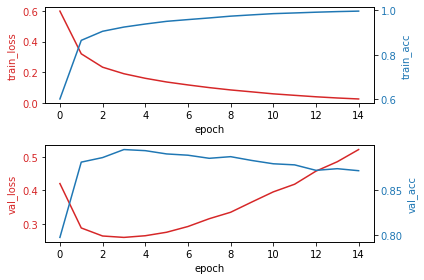

In [18]:
show_acc.plot(history1)

过拟合了，最高准确率大概89%

# Save Learned Word Embedding
有时候在大规模预料上训练得到的embedding layer是可以继续拿来在其他task中使用的

In [19]:
weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

## 在Embedding Projector中可视化
[Embedding Projector](http://projector.tensorflow.org/)是一个高维数据可视化工具，可以用来可视化我们的word embedding结果

In [20]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if  index == 0: continue # skip 0, it's padding.
    vec = weights[index] 
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

去upload试一下吧

# 使用RNN

In [21]:
model2=tf.keras.Sequential([
    vectorize_layer,
    Embedding(vocab_size, 64, name="embedding",mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [22]:
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
history2 = model2.fit(train_ds, epochs=15,
                    validation_data=val_ds)

Epoch 1/15
313/313 [==============================] - 61s 146ms/step - loss: 0.6703 - accuracy: 0.5238 - val_loss: 0.3449 - val_accuracy: 0.8478
Epoch 2/15
313/313 [==============================] - 42s 134ms/step - loss: 0.3206 - accuracy: 0.8676 - val_loss: 0.2791 - val_accuracy: 0.8860
Epoch 3/15
313/313 [==============================] - 42s 135ms/step - loss: 0.2126 - accuracy: 0.9200 - val_loss: 0.2810 - val_accuracy: 0.8740
Epoch 4/15
313/313 [==============================] - 42s 135ms/step - loss: 0.1860 - accuracy: 0.9335 - val_loss: 0.2774 - val_accuracy: 0.8910
Epoch 5/15
313/313 [==============================] - 42s 135ms/step - loss: 0.1211 - accuracy: 0.9612 - val_loss: 0.3015 - val_accuracy: 0.8832
Epoch 6/15
313/313 [==============================] - 42s 136ms/step - loss: 0.0994 - accuracy: 0.9723 - val_loss: 0.3239 - val_accuracy: 0.8862
Epoch 7/15
313/313 [==============================] - 43s 136ms/step - loss: 0.0804 - accuracy: 0.9787 - val_loss: 0.3989 - val_ac

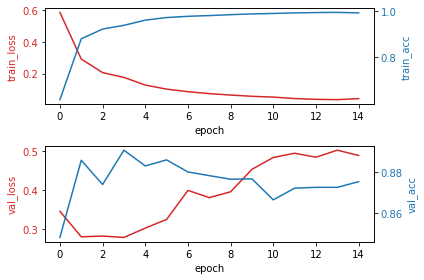

In [24]:
show_acc.plot(history2)

最终效果和没用RNN差不多，推测原因是情感分类可能取决于一些能表明情绪的关键词，如recommend, dislike等，和语序等关系不大，所以RNN能记住上下文的特性在这一任务中用途不大，并没有带来很大的提升。